import urllib.request

url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
week_nums = [190504, 190511, 190518, 190525, 190601, 190608, 190615, 190622, 190629, 190706, 190713, 190720, 190727]

for week_num in week_nums:
    urllib.request.urlretrieve(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt",
                               f"data/turnstile_{week_num}.txt")

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

engine = create_engine("sqlite:///mta2.db")
all_data = pd.read_sql('SELECT * FROM mta_data2;', engine)

In [ ]:
%config InlineBackend.figure_format = 'png'
%matplotlib inline 

In [2]:
df = all_data

In [4]:
# Need to change columns to row-index 0
df.rename(columns = df.loc[2], inplace =True)

# Remove row 0,1,2
df = df.drop(df.index[[0,1,2]], inplace=True)

In [6]:
df = all_data
#Drop Dups
df.drop_duplicates(inplace=True)

In [7]:
# Need to convert EXITS column field11 into numeric type
df['EXITS'] = df['EXITS'].astype(np.float64)

In [ ]:
df.info()

In [8]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,AREA
3,A002,R051,02-00-00,59 ST-BMT,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,0007035249,2384833.0,BROOKLYN
4,A002,R051,02-00-00,59 ST-BMT,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,0007035269,2384840.0,BROOKLYN
5,A002,R051,02-00-00,59 ST-BMT,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,0007035292,2384875.0,BROOKLYN
6,A002,R051,02-00-00,59 ST-BMT,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,0007035392,2384951.0,BROOKLYN
7,A002,R051,02-00-00,59 ST-BMT,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,0007035651,2385020.0,BROOKLYN


In [49]:
# Need to find the max(EXITS) for each (SCP) by DATE
#This excludes the EXITS count from TIME 20:00-23:59 each day. The data from this date frame is not as relevant to my company of interest.
#The EXITS count during this time is likely minimal. Additionally, scooters are reclaimed at night to charge to be redeployed the next morning.
#I used .shift method with PREV_EXITS initially. However, for C/A==S101A, SCP==01-00-03 between 05/01/2019 and 05/02/2019 there was an unexplained jump from 432 to 1078346838.
max_exit = df.groupby(['C/A','SCP','STATION','DATE','AREA'])[['EXITS']].max()

In [50]:
# Need to find the min(EXITS) for each (SCP) by DATE
min_exit = df.groupby(['C/A','SCP','STATION','DATE','AREA'])[['EXITS']].min()

In [51]:
#Merging total scp exits data into one df, on matching SCP column
total_scp_exit = pd.merge(max_exit, min_exit, on=['C/A','SCP','STATION','DATE','AREA'])
total_scp_exit.head()

EXITS_x    EXITS_y
C/A  SCP      STATION   DATE       AREA                          
A002 02-00-00 59 ST-BMT 04/27/2019 BROOKLYN  2385070.0  2384833.0
                        04/28/2019 BROOKLYN  2385240.0  2385087.0
                        04/29/2019 BROOKLYN  2385732.0  2385256.0
                        04/30/2019 BROOKLYN  2386197.0  2385765.0
                        05/01/2019 BROOKLYN  2386673.0  2386229.0

In [52]:
# total_scp_exits = max-min for each turnstile SCP per DATE BETWEEN 00:00 and ~20:00 (or last time-count)
total_scp_exit['exits_per_day'] = total_scp_exit['EXITS_x']-total_scp_exit['EXITS_y']
total_scp_exit.head()

EXITS_x    EXITS_y  \
C/A  SCP      STATION   DATE       AREA                             
A002 02-00-00 59 ST-BMT 04/27/2019 BROOKLYN  2385070.0  2384833.0   
                        04/28/2019 BROOKLYN  2385240.0  2385087.0   
                        04/29/2019 BROOKLYN  2385732.0  2385256.0   
                        04/30/2019 BROOKLYN  2386197.0  2385765.0   
                        05/01/2019 BROOKLYN  2386673.0  2386229.0   

                                             exits_per_day  
C/A  SCP      STATION   DATE       AREA                     
A002 02-00-00 59 ST-BMT 04/27/2019 BROOKLYN          237.0  
                        04/28/2019 BROOKLYN          153.0  
                        04/29/2019 BROOKLYN          476.0  
                        04/30/2019 BROOKLYN          432.0  
                        05/01/2019 BROOKLYN          444.0

In [69]:
#There are some large inexplicable jumps in the EXITS count for a single SCP
total_scp_exit.sort_values(['exits_per_day'], ascending=False)

EXITS_x      EXITS_y  \
C/A   SCP      STATION       DATE       AREA                                   
C008  00-00-00 DEKALB AV     07/26/2019 BROOKLYN   1.850345e+09    8702864.0   
N207  00-00-00 167 ST        06/14/2019 BRONX      1.828766e+09    7175686.0   
R401  00-00-00 3 AV 138 ST   07/14/2019 BRONX      1.426011e+09   11255249.0   
R258  00-06-00 125 ST        07/04/2019 MANHATTAN  1.409339e+09    5560810.0   
R311  00-00-00 3 AV-149 ST   06/19/2019 BRONX      1.476891e+09  123244243.0   
...                                                         ...          ...   
N120  00-05-00 UTICA AV      06/04/2019 BROOKLYN   0.000000e+00          0.0   
                             06/03/2019 BROOKLYN   0.000000e+00          0.0   
                             06/02/2019 BROOKLYN   0.000000e+00          0.0   
                             06/01/2019 BROOKLYN   0.000000e+00          0.0   
TRAM2 00-05-01 RIT-ROOSEVELT 07/26/2019 MANHATTAN  3.830000e+02        383.0   

                                                   exits_per_day  
C/A   SCP      STATION       DATE       AREA                      
C008  00-00-00 DEKALB AV     07/26/2019 BROOKLYN    1.841642e+09  
N207  00-00-00 167 ST        06/14/2019 BRONX       1.821591e+09  
R401  00-00-00 3 AV 138 ST   07/14/2019 BRONX       1.414756e+09  
R258  00-06-00 125 ST        07/04/2019 MANHATTAN   1.403778e+09  
R311  00-00-00 3 AV-149 ST   06/19/2019 BRONX       1.353647e+09  
...                                                          ...  
N120  00-05-00 UTICA AV      06/04/2019 BROOKLYN    0.000000e+00  
                             06/03/2019 BROOKLYN    0.000000e+00  
                             06/02/2019 BROOKLYN    0.000000e+00  
                             06/01/2019 BROOKLYN    0.000000e+00  
TRAM2 00-05-01 RIT-ROOSEVELT 07/26/2019 MANHATTAN   0.000000e+00  

[413541 rows x 3 columns]

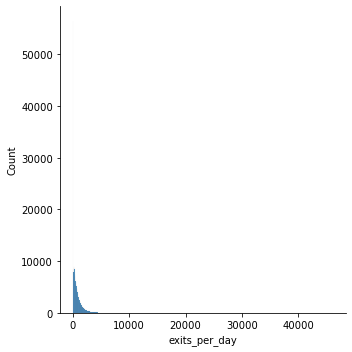

In [72]:
sns.displot(total_scp_exit[(total_scp_exit.exits_per_day <51325)].exits_per_day)
#This shows distribution of exits_per_day values

In [71]:
total_scp_exit.describe()

,EXITS_x,EXITS_y,exits_per_day
count,4.135410e+05,4.135410e+05,4.135410e+05
mean,3.615268e+07,3.610136e+07,5.132585e+04
std,2.013725e+08,2.012513e+08,7.086530e+06
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.074170e+05,2.064270e+05,1.520000e+02
50%,1.422380e+06,1.420913e+06,4.610000e+02
75%,4.961140e+06,4.958675e+06,1.006000e+03
max,2.124127e+09,2.124125e+09,1.841642e+09


In [77]:
#Remove SCP exits_per_day values > 51325
total_scp_exit2 = total_scp_exit[(total_scp_exit.exits_per_day <51325)]

In [79]:
#Find AVG EXITS per day per STATION.
avg_daily_exit = total_scp_exit2.groupby(['STATION','DATE','AREA'])[['exits_per_day']].sum()
avg_daily_exit.head()

exits_per_day
STATION DATE       AREA                    
1 AV    04/27/2019 MANHATTAN         7198.0
        04/28/2019 MANHATTAN         5370.0
        04/29/2019 MANHATTAN        18262.0
        04/30/2019 MANHATTAN        18519.0
        05/01/2019 MANHATTAN        19184.0

In [80]:
avg_daily_exit.describe()

,exits_per_day
count,33822.000000
mean,9091.422033
std,15627.489089
min,0.000000
25%,1920.000000
50%,4181.000000
75%,9210.250000
max,158369.000000


In [56]:
#Group by STATION and return the mean of daily exits of all SCP per C/A
station_daily = avg_daily_exit.groupby(['STATION','AREA'])[['exits_per_day']].mean()
station_daily.head(15)

,,exits_per_day
STATION,AREA,
1 AV,MANHATTAN,14497.769231
103 ST,MANHATTAN,15729.142857
103 ST-CORONA,QUEENS,10208.659341
104 ST,QUEENS,1430.538462
110 ST,MANHATTAN,6932.659341
111 ST,QUEENS,6228.582418
116 ST,MANHATTAN,15001.527473
116 ST-COLUMBIA,MANHATTAN,5029.461538
121 ST,QUEENS,1135.263736


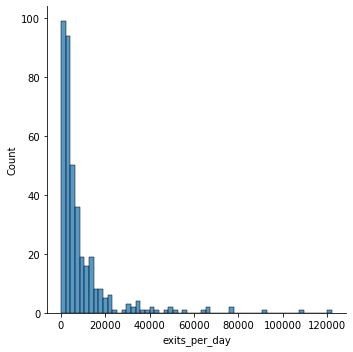

In [38]:
sns.displot(station_daily.exits_per_day)

In [57]:
#Sorting DESC to find top 10 stations
station_daily = station_daily.sort_values(by=['exits_per_day'],ascending=False).round(decimals=2)
station_daily.head(10)

,,exits_per_day
STATION,AREA,
34 ST-PENN STA,MANHATTAN,122217.98
GRD CNTRL-42 ST,MANHATTAN,109232.98
34 ST-HERALD SQ,MANHATTAN,91426.26
14 ST-UNION SQ,MANHATTAN,76886.62
TIMES SQ-42 ST,MANHATTAN,76234.02
42 ST-PORT AUTH,MANHATTAN,65942.90
23 ST,MANHATTAN,65686.26
FULTON ST,MANHATTAN,64196.67
86 ST,MANHATTAN,56039.32


In [58]:
station_daily.reset_index(inplace=True)

In [59]:
station_top10=station_daily.head(10)

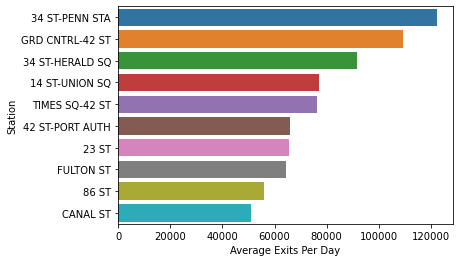

In [60]:
top_10 = sns.barplot(data=station_top10, x='exits_per_day', y='STATION')
top_10.set(xlabel='Average Exits Per Day', ylabel='Station')
top_10.figure.savefig("Top10.png", bbox_inches='tight')

SELECT * FROM mta_data m
LEFT JOIN neighborhoods n ON m.field4 = n.field1
#----
UPDATE mta_data
SET field4 ='PARK PLACE-IRT'
WHERE field4 ='PARK PLACE' AND field6 ='IRT'
#----
UPDATE mta_data
SET field4 ='PARK PLACE-BMT'
WHERE field4 ='PARK PLACE' AND field6 ='BMT' 
#----
UPDATE mta_data
SET field4 ='BROADWAY-BMT'
WHERE field4 ='BROADWAY' AND field6='BMT'
#----  
UPDATE mta_data    
SET field4 ='BROADWAY-IND'
WHERE field4 ='BROADWAY' AND field6='IND'
#----
UPDATE mta_data
SET field4 ='59 ST-IRT'
WHERE field4 ='59 ST' AND field6='IRT'
#----
UPDATE mta_data
SET field4 ='59 ST-BMT'
WHERE field4 ='59 ST' AND field6='BMT'
#----#
UPDATE mta_data
SET field4 ='7 AV-BDE'
WHERE field4 ='7 AV' AND field5='BDE'
#----
UPDATE mta_data
SET field4 ='8 AV-N'
WHERE field4 ='8 AV' AND field6='N'
#----
UPDATE mta_data
SET field4 ='PROSPECT AV-2-5'
WHERE field4 ='PROSPECT AV' AND field5='25'
#----
UPDATE mta_data
SET field4 ='50 ST-D'
WHERE Field4 ='50 ST' AND field5='D'
#----
UPDATE mta_data
SET field4 ='77 ST-R'
WHERE Field4 ='77 ST' AND field5='R'
#----
UPDATE mta_data
SET field4 ='79 ST-D'
WHERE Field4 ='79 ST' AND field5='D'
#----
UPDATE mta_data
SET field4 ='86 ST-R'
WHERE Field4 ='86 ST' AND field5='R'
#----
UPDATE mta_data
SET field4 ='FULTON ST-G'
WHERE Field4 ='FULTON ST' AND field5='G'
#----
UPDATE mta_data
SET field4 ='GRAND-ST-L'
WHERE Field4 ='GRAND ST' AND field5='L'


SELECT DISTINCT field4 FROM mta_data m
LEFT JOIN neighborhoods n ON m.field4 = n.field1
WHERE n.field2 IS NULL

FUTURE WORK: predictive model, include rental data from companies at specific stations

# Finding TOP 5 Stations Per Borough

In [61]:
#Masks for each borough of interest
brooklyn = (station_daily.AREA == 'BROOKLYN')
bronx = (station_daily.AREA == 'BRONX')
queens = (station_daily.AREA == 'QUEENS')
manhattan = (station_daily.AREA == 'MANHATTAN')

In [63]:
station_daily[brooklyn].head(5)

,STATION,AREA,exits_per_day
17,FLUSHING-MAIN,BROOKLYN,35004.62
23,ATL AV-BARCLAY,BROOKLYN,31352.88
37,JAY ST-METROTEC,BROOKLYN,19763.36
38,CHURCH AV,BROOKLYN,18603.76
42,BOROUGH HALL,BROOKLYN,17891.07


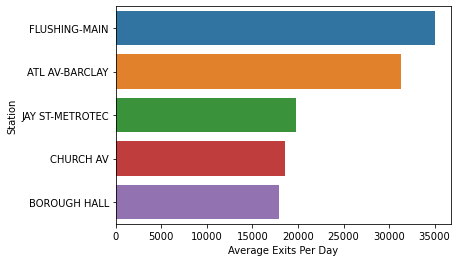

In [66]:
brooklyn_top5 = sns.barplot(data=station_daily[brooklyn].head(5), x='exits_per_day', y='STATION')
brooklyn_top5.set(xlabel='Average Exits Per Day', ylabel='Station')
brooklyn_top5.figure.savefig("brooklyn_top5.png", bbox_inches='tight')

In [64]:
station_daily[bronx].head()

,STATION,AREA,exits_per_day
63,161/YANKEE STAD,BRONX,13612.85
75,PARKCHESTER,BRONX,11973.87
94,167 ST,BRONX,9281.60
96,GUN HILL RD,BRONX,8851.09
103,KINGSBRIDGE RD,BRONX,8356.90


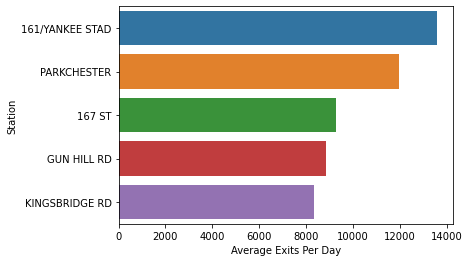

In [67]:
bronx_top5 = sns.barplot(data=station_daily[bronx].head(5), x='exits_per_day', y='STATION')
bronx_top5.set(xlabel='Average Exits Per Day', ylabel='Station')
bronx_top5.figure.savefig("bronx_top5.png", bbox_inches='tight')

In [65]:
station_daily[queens].head()

,STATION,AREA,exits_per_day
26,JKSN HT-ROOSVLT,QUEENS,27608.25
34,JAMAICA CENTER,QUEENS,20795.92
36,KEW GARDENS,QUEENS,20030.29
49,SUTPHIN-ARCHER,QUEENS,15302.24
59,61 ST WOODSIDE,QUEENS,13970.08


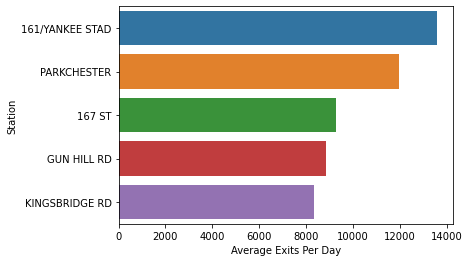

In [68]:
queens_top5 = sns.barplot(data=station_daily[bronx].head(5), x='exits_per_day', y='STATION')
queens_top5.set(xlabel='Average Exits Per Day', ylabel='Station')
queens_top5.figure.savefig("queens_top5.png", bbox_inches='tight')